# Init

In [1]:
%cd "~/Projects/Segmentation/TreeSeg"
import json
import math
import os
from pathlib import Path

import hashlib
import matplotlib.pyplot as plt
import networkx as nx
import nvdiffrast.torch as dr
import torch
from torch import Tensor, nn
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
import yaml
from rich.console import Console
from rich.tree import Tree
import torch_geometric as pyg

import tree_segmentation as ts
import tree_segmentation.extension as ext
from tree_segmentation.extension import ops_3d, Mesh, utils
from semantic_sam import SemanticSAM, semantic_sam_l
from tree_segmentation import Tree3Dv2, Tree3D, TreePredictor, TreeSegmentMetric, Tree2D
from tree_segmentation.util import show_masks, show_all_levels, get_hash_name
from evaluation.batch_eval_PartNet import get_mesh_and_gt_tree, get_images

/home/wan/Projects/Segmentation/TreeSeg
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


2023-08-05 11:37:43.204505: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-05 11:37:44.312870: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/wan/miniconda3/envs/wan/lib/python3.8/site-packages/cv2/../../lib64:/usr/local/cuda-11.7/lib64:/usr/local/cuda-11.7/lib64:/usr/local/cuda-11.7/lib64:/usr/local/cuda-11.7/lib64:/usr/local/cuda-11.7/lib64:
2023-08-05 11:37:44.313000: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so

In [2]:
print(torch.__version__)
%load_ext autoreload
%autoreload 2
%matplotlib inline

2.0.1+cu117


In [3]:
torch.set_grad_enabled(False)
console = Console()
device = torch.device("cuda")
# device = torch.device("cpu")
cache_root = Path('~/wan_code/segmentation/tree_segmentation/results').expanduser()
utils.set_printoptions(linewidth=120)

In [4]:
data_root = Path('~/data/PartNet/data_v0').expanduser()
print(f"Data Root: {data_root}")
shapes = list(os.scandir(data_root))
print(f'There are {len(shapes)} shapes')

Data Root: /home/wan/data/PartNet/data_v0
There are 32537 shapes


In [5]:
# example = data_root.joinpath('12012')
example = data_root.joinpath('22835')
# example = data_root.joinpath('27774')
print(f"Example dir", example)
cache_dir = cache_root.joinpath(get_hash_name(example.joinpath('objs')))
cache_dir.mkdir(exist_ok=True)
print('Cache Dir:', cache_dir)
# with example.joinpath('meta.json').open('r') as f:
#     meta = json.load(f)
# print('meta:', meta)
# with example.joinpath('result_after_merging.json').open('r') as f:
#     meta_parts = json.load(f)
# print(list(os.scandir(example)))
# for item in os.scandir(example):
#     print('=' * 20, item.name, '=' * 20)
#     if item.name.endswith('.json'):
#         with example.joinpath(item.name).open('r') as f:
#             data = json.load(f)
#             print(yaml.dump(data))

Example dir /home/wan/data/PartNet/data_v0/22835
Cache Dir: /home/wan/wan_code/segmentation/tree_segmentation/results/1b44f4e4724b07e54df71eef5e7f6d28


In [6]:
if cache_dir.joinpath(example.stem + '.mesh_cache').exists() and cache_dir.joinpath('gt.tree3dv2').exists():
    mesh = torch.load(cache_dir.joinpath(example.stem + '.mesh_cache'), map_location=device)
    gt = Tree3Dv2(mesh, device=device)
    gt.load(cache_dir.joinpath('gt.tree3dv2'))
else:
    mesh, gt = get_mesh_and_gt_tree(example, cache_dir)
print(mesh, gt)
gt.print_tree()

[Tree3D] load results from: /home/wan/wan_code/segmentation/tree_segmentation/results/1b44f4e4724b07e54df71eef5e7f6d28/gt.tree3dv2
Mesh(vertices=75979, faces=30568) <tree_segmentation.tree_3d_segmentation.Tree3Dv2 object at 0x7efed2cf35b0>


0: Tree Root
├── 1
└── 2
    ├── 3
    ├── 4
    ├── 5
    ├── 6
    ├── 7
    ├── 8
    ├── 9
    ├── 10
    ├── 11
    │   ├── 13
    │   └── 14
    └── 12
        ├── 15
        └── 16

F32Tensor[100, 1024, 1024, 3], IntTensor[100, 1024, 1024], F32Tensor[100, 4, 4]


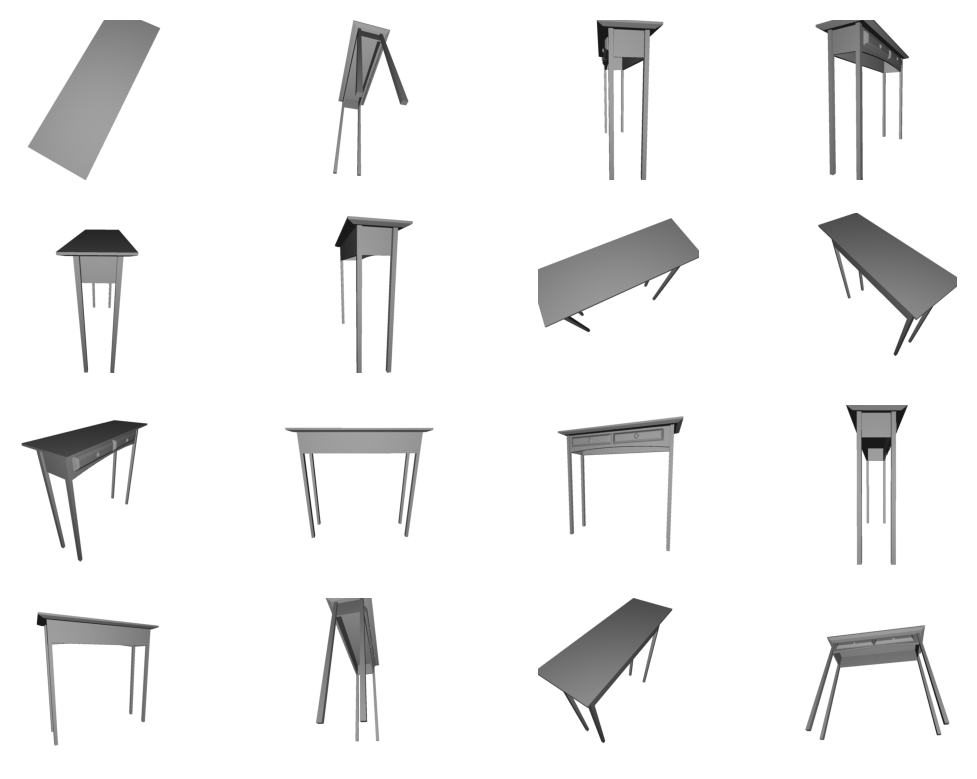

In [7]:
num_views = 100
images, tri_ids, Tw2vs = get_images(mesh.to(device), image_size=1024, num_views=num_views, seed=42)
images, tri_ids, Tw2vs = images.cpu(), tri_ids.cpu(), Tw2vs.cpu()
print(utils.show_shape(images, tri_ids, Tw2vs))
plt.figure(dpi=200)
for i in range(min(16, images.shape[0])):
    plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].cpu().numpy())
    plt.axis('off')

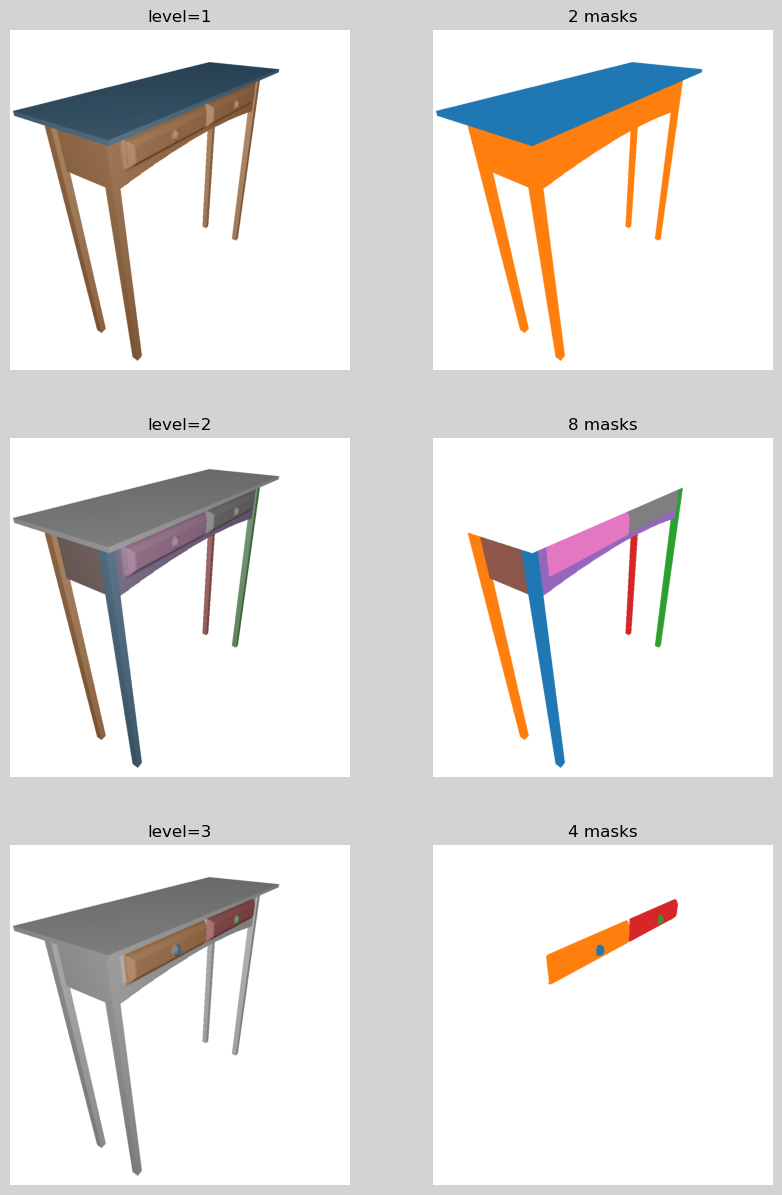

In [8]:
show_index = 8
num_level = show_all_levels(images[show_index, :, :, :3], gt, tri_ids[show_index], facecolor='lightgray')
plt.show()

# Fast Segment 2D

In [9]:
ckpt_path = Path("~/models/segmentation/Semantic-SAM/swinl_only_sam_many2many.pth").expanduser()
model = semantic_sam_l(ckpt_path).eval().to(device)
print(model.__class__.__name__)
predictor = TreePredictor(model)

SemanticSAM


In [ ]:
show_index = 8
image = images[show_index, :, :, :3]
print('image:', utils.show_shape(image))
tree_data = predictor.generate(
    (image.cpu().numpy() * 255).astype(np.uint8),
    max_iters=100,
    in_threshold=0.9,
    union_threshold=0.1,
    min_mask_region_area=100,
    points_per_update=256,
    device=device,
    in_thre_area=50,
)
show_all_levels(image, tree_data, facecolor='lightgray', width=6)

In [ ]:
def build_view_graph(area, tri_ids: Tensor, threshold=0.5, num_nearest=5):
    N_view = tri_ids.shape[0]
    view_masks = torch.zeros((N_view, area.shape[0] + 1), device=device)
    for i in range(N_view):
        v_faces = tri_ids[i].unique()
        if v_faces[0] == 0:
            v_faces = v_faces[1:]
        view_masks[i, v_faces] = 1
    # print(area.shape)
    A = F.linear(view_masks[:, 1:], view_masks[:, 1:] * area)
    mask_area = torch.mv(view_masks[:, 1:], area)
    # A = A / (area[:, None] + area[None, :] - A).clamp_min(1e-7)
    A = A / mask_area[:, None]
    indices = torch.topk(A, num_nearest + 1, dim=0)[1]
    # print(utils.show_shape(indices))
    A = A.ge(threshold)
    A[torch.arange(N_view), indices] = 1
    return A


# Gv = build_view_graph(gt.area, tri_ids)
# print(utils.show_shape(Gv))

In [ ]:
features_2d = []
for i in tqdm(range(num_views)):
    continue
    predictor.set_image((images[i, :, :, :3] * 255).to(torch.uint8).cpu().numpy())
    features_2d.append(utils.tensor_to(predictor.features, device=torch.device('cpu')))
print(utils.show_shape(features_2d))

In [ ]:
results_2d = [Tree2D(device=device) for _ in range(num_views)]
for i in tqdm(range(num_views)):
    continue
    points = results_2d[i].sample_grid(32)
    predictor.features = utils.tensor_to(features_2d[i], device=device)
    data = predictor.process_points(points)
    results_2d[i].cat(data)
    results_2d[i].update_tree()
    results_2d[i].remove_not_in_tree()
    results_2d[i].compress()
for j in range(10):
    for i in tqdm(range(num_views)):
        points = []

# Slow Segment 2D

In [14]:
# from rich.progress import track
from IPython.display import clear_output

for index in tqdm(range(num_views)):
    index = 8
    if 0 and cache_dir.joinpath(f"view_{index:04d}.data").exists():
        data = torch.load(cache_dir.joinpath(f"view_{index:04d}.data"), map_location='cpu')
        assert torch.all(data['tri_id'].eq(tri_ids[index].cpu()))
    else:
        tree_data = predictor.generate(
            (images[index, :, :, :3].cpu().numpy() * 255).astype(np.uint8),
            max_iters=100,
            in_threshold=0.9,
            union_threshold=0.1,
            min_mask_region_area=100,
            points_per_update=256,
            device=device,
            in_thre_area=50,
            verbose=1,
        )
        data = {
            'tree_data': tree_data.save(filename=None),
            'tri_id': tri_ids[index].clone(),
            'image': images[index].clone(),
            'Tw2v': Tw2vs[index].clone(),
        }
        torch.save(data, cache_dir.joinpath(f"view_{index:04d}.data"))

    clear_output(wait=True)
    break

  0%|                                                                                                                                                | 0/100 [00:16<?, ?it/s]


0: Tree Root
├── 1
│   ├── 3
│   └── 4
└── 2
    ├── 5
    │   ├── 8
    │   │   ├── 15
    │   │   │   ├── 18
    │   │   │   └── 19
    │   │   └── 16
    │   │       ├── 20
    │   │       ├── 21
    │   │       └── 22
    │   ├── 9
    │   └── 10
    ├── 6
    │   ├── 11
    │   └── 12
    │       └── 17
    └── 7
        ├── 13
        └── 14

BoolTensor[22, 1024, 1024], None, F16Tensor[22]
tensor([ 1,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21], device='cuda:0') BoolTensor[22, 1024, 1024], None, F16Tensor[22]
tensor([ 0,  3,  2,  1, 10,  9,  8,  7,  6,  5,  4, 13, 12, 11, 18, 17, 16, 15, 14], device='cuda:0') BoolTensor[19, 1024, 1024], LongTensor[19], F16Tensor[19]


0: Tree Root
└── 1
    ├── 2
    │   ├── 5
    │   └── 6
    ├── 3
    │   ├── 7
    │   │   └── 12
    │   └── 8
    └── 4
        ├── 9
        ├── 10
        └── 11
            ├── 13
            │   ├── 15
            │   ├── 16
            │   └── 17
            └── 14
                ├── 18
                └── 19

True


6

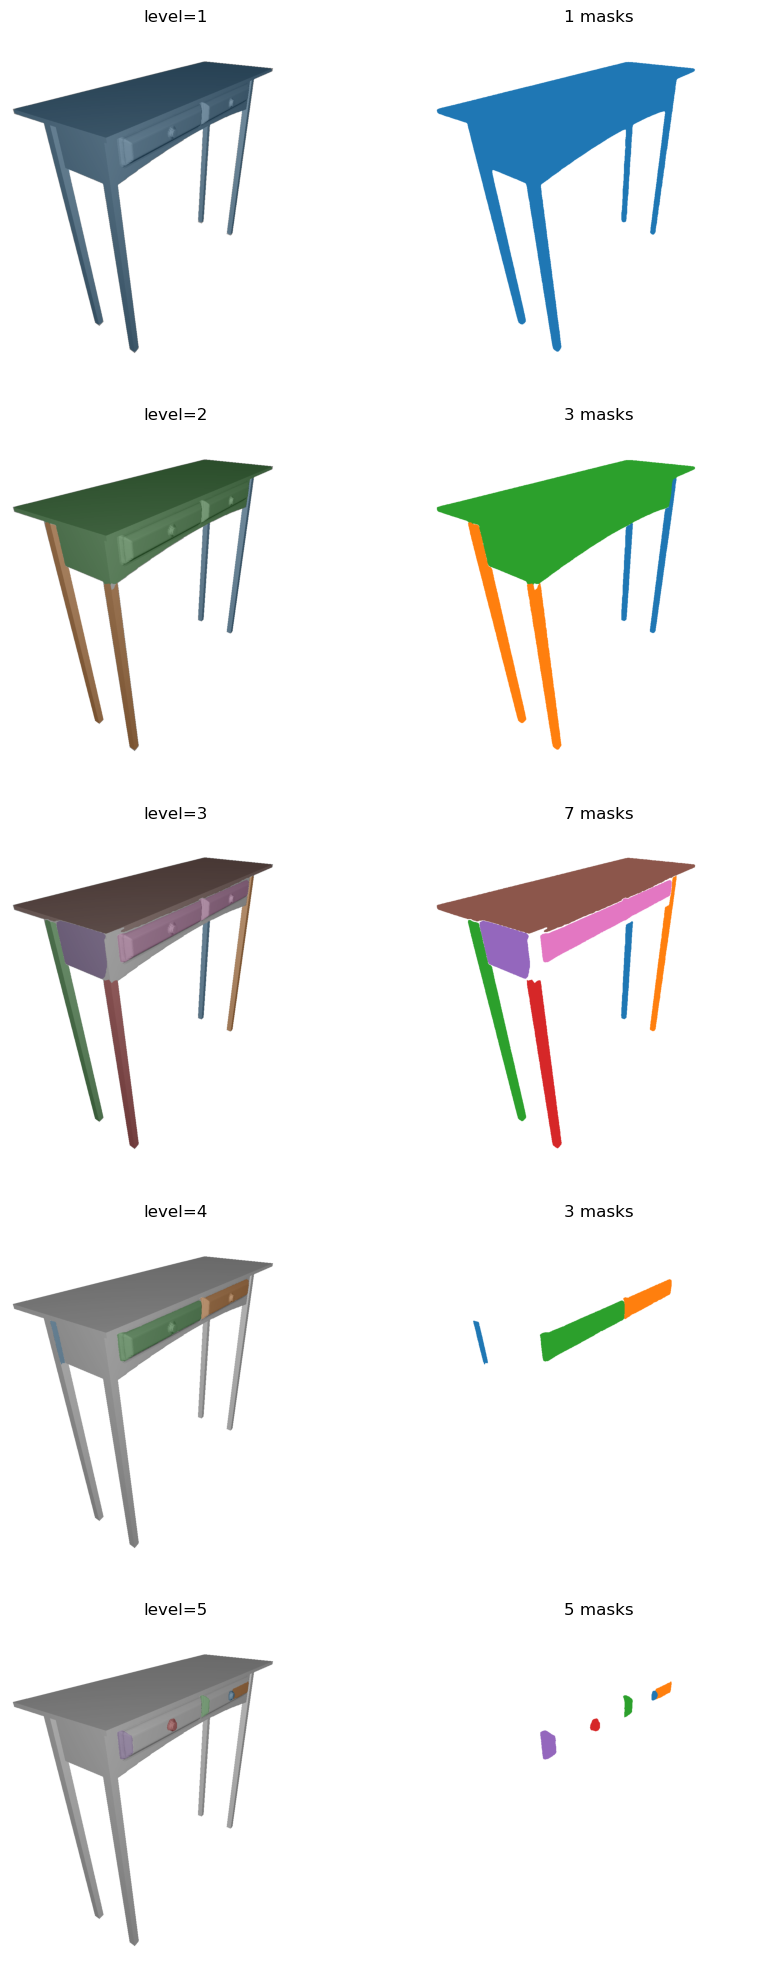

In [19]:
show_index = 8
data = torch.load(cache_dir.joinpath(f"view_{show_index:04d}.data"))
tree_data = Tree2D(device=device)
tree_data.load(None, **data['tree_data'])
tree_data.print_tree()
tree_data.remove_background(tri_ids[show_index].eq(0).to(device))
tree_data.print_tree()
print(isinstance(tree_data, Tree2D))
show_all_levels(images[show_index, :, :, :3], tree_data)

# 3D Tree Segmentation

In [ ]:
from tree_segmentation import Tree3Dv2

timer = utils.TimeWatcher()
timer.start()
tree3d = Tree3Dv2(mesh, device=device)
timer.log('new')
# tree3d.load(cache_dir.joinpath('my.tree3dv2'))
tree3d.load_2d_results(cache_dir, pack=True)
timer.log('load 2d')
Gv = tree3d.build_view_graph()
timer.log('Gv')
Gm = tree3d.build_graph(Gv)
timer.log('Gm')
X, autoencoder = tree3d.compress_masks(epochs=3000)
timer.log('X')
print(autoencoder)
print(timer)

In [ ]:
K = tree3d.Lmax * 2
gnn = pyg.nn.GCN(in_channels=X.shape[1], hidden_channels=128, num_layers=2, out_channels=K, norm='BatchNorm').to(device)
print(gnn)
tree3d.run(epochs=5000, K=K, gnn=gnn, A=Gm * Gm.ge(0.5), X=X, topP=False)
tree3d.save(cache_dir.joinpath('my.tree3dv2'))

In [ ]:
tree3d.run(epochs=5000, K=K, gnn=gnn, A=Gm * Gm.ge(0.5), X=X, topP=True)

In [ ]:
print(tree3d.scores)
# tree3d.set_score_threshold(0.5)
show_index = 8
show_all_levels(images[show_index, :, :, :3], tree3d, tri_ids[show_index])
tree3d.print_tree()
print(utils.show_shape(tree3d.masks))
# tree3d.save(cache_dir.joinpath('my.tree3dv2'))

from tree_segmentation.metric import TreeSegmentMetric

metric = TreeSegmentMetric()
metric.update(tree3d.to(device), gt.to(device))
print(metric.PQ, metric.TQ)
# tree3d.print_tree()
# pack 0.3105152130126953 0.2907191812992096
# unpack: 0.3666433095932007 0.2955842912197113

# 3D Tree Segmentation use GT 2D results

In [ ]:
from tree_segmentation.tree_3d_segmentation import Tree3Dv2

tree3d_gt = Tree3Dv2(mesh, device, verbose=1)
tree3d_gt.build_gt_segmentation(gt, tri_ids)
Gv_ = tree3d_gt.build_view_graph()
Gm_ = tree3d_gt.build_graph(Gv_)
X_, autoencoder = tree3d_gt.compress_masks(epochs=3000)
print(autoencoder)
print(utils.show_shape(Gv_, Gm_, X_))

In [ ]:
print('view graph:', Gv_.shape, 'edges:', Gv_.sum().item())

G_ = nx.Graph()
G_.add_nodes_from(range(Gv_.shape[0]))
for ab in torch.nonzero(Gv_):
    a, b = ab[0].item(), ab[1].item()
    if a < b:
        G_.add_edge(a, b)
plt.figure(figsize=(10, 10))
nx.draw(G_, node_size=5)
plt.show()


In [ ]:
K = gt.cnt * 2
gnn = pyg.nn.GCN(in_channels=X_.shape[1], hidden_channels=128, num_layers=2, out_channels=K, norm='BatchNorm').cuda()
print(gnn)

tree3d_gt.run(epochs=5000, K=K, gnn=gnn, A=Gm_ * (Gm_ > 0.5), X=X_)
# tree3d_gt.save(cache_dir.joinpath('gt_seg.tree3dv2'))

In [ ]:
tree3d_gt.save(cache_dir.joinpath('gt_seg.tree3dv2'))
print(tree3d_gt.scores, tree3d_gt)

In [ ]:
# tree3d_gt.in_threshold = 0.9
# tree3d_gt.set_score_threshold(0.7)
show_index = 8
show_all_levels(images[show_index, :, :, :3], tree3d_gt, tri_ids[show_index])
# tree3d_gt.node_rearrange()
tree3d_gt.print_tree()
metric = TreeSegmentMetric()
metric.update(tree3d_gt.to(device), gt.to(device))
for k, v in metric.summarize().items():
    print(k, v)
# without tree loss: 0.5807471451935945 0.4203405976295471
# with tree loss:0.733435549054827 0.5524243116378784

# Other Attempt

In [ ]:
@torch.enable_grad()
def run(Adj: Tensor, Attr: Tensor, t: Tree3Dv2, epochs=5000):
    gnn = pyg.nn.GCN(
        in_channels=X_.shape[1], hidden_channels=128, num_layers=2, out_channels=128, norm='BatchNorm').cuda()

    opt = torch.optim.Adam(gnn.parameters(), lr=5e-4)
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, epochs, 1e-6)

    edges = torch.nonzero(Adj).T
    edge_weights = Adj[edges[0], edges[1]]
    print(utils.show_shape(edges, edge_weights))

    for epoch in range(epochs):
        opt.zero_grad()
        view_index = torch.randint(0, t.N_view, (1,)).item()
        view_mask = t.view_infos[view_index][0]
        print('view_mask', utils.show_shape(view_mask))
        features = gnn(Attr, edges, edge_weight=edge_weights)
        print(utils.show_shape(features))
        start_index, end_index = t.view_range[view_index]
        for u in range(start_index, end_index):
            linked = edges[1, edges[0] == u]
            scores = 1 - F.relu(-torch.mv(features[linked], features[u]))  # shape: [Nu]
            linked = F.pad(linked, (0, 1), value=u)
            scores = F.pad(scores, (0, 1), value=1)  # TODO: 权重参数化
            mask_u = scores @ t.face_masks[linked]  # shape: [Nu, F]
            print(utils.show_shape(scores, linked, t.view_masks[t.view_indices[linked]], mask_u))
            mask_u = mask_u / (scores @ t.view_masks[t.view_indices[linked]]).clamp_min(1e-7)
            mask_u = mask_u[view_mask]
            print((mask_u - t.face_masks[u, view_mask]).abs().sum())
            diff = F.mse_loss(mask_u, t.face_masks[u, view_mask])  # to FocalLoss
            print(utils.show_shape(mask_u), diff)
            # print(u, utils.show_shape(linked, scores), linked, scores)
        opt.step()
        lr_scheduler.step()
        break


run(Gm_ * (Gm_ >= 0.5), X, tree3d_gt)

# Simple Merge

In [ ]:
my = Tree3Dv2(mesh, device=device)
my.build_gt_segmentation(gt, tri_ids)
my.build_graph(my.build_view_graph())

In [ ]:
def get_score(tree: Tree3Dv2, indices: Tensor, Mask: Tensor = None):
    if not isinstance(indices, Tensor):
        indices = torch.tensor(indices, device=tree.device)
    view_mask_ = tree.view_masks[tree.view_indices[indices], 1:]
    masks_ = tree.face_masks[indices, 1:]
    # print(utils.show_shape(indices, view_mask_, masks_))
    if Mask is None:
        Mask = (masks_.sum(dim=0) / view_mask_.sum(dim=0).clamp_min(1e-7)) >= 0.5
    masks_M = Mask[None, :] * view_mask_
    area_M = torch.mv(masks_M, tree.area)
    area_m = torch.mv(masks_, tree.area)
    inter = (masks_M * masks_ * tree.area).sum(dim=1)
    iou = inter / (area_m + area_M - inter).clamp_min(1e-7)
    # print(iou)
    return iou.mean()


# assert 0 <= my.face_masks.min() and my.face_masks.max() <= 1., my.face_masks.aminmax()
def run_simple_merge(tree: Tree3Dv2, threshold=0.9, num_min=2):
    visited = torch.zeros(tree.M, device=tree.device, dtype=torch.bool)
    masks = []

    for i in range(tree.M):
        if visited[i]:
            continue
        visited[i] = True
        mask = tree.face_masks[i].clone()
        cnt = tree.view_masks[tree.view_indices[i]].clone()
        que = [i]

        while True:
            update = False
            for k in range(tree.M):
                if not visited[k] and (tree.A[que, k] >= 0.5).any():
                    mask_k, cnt_k = tree.face_masks[k], tree.view_masks[tree.view_indices[k]]
                    mask_ = (mask + mask_k) / (cnt + cnt_k).clamp_min(1e-7) >= 0.5
                    score = get_score(tree, que + [k], mask_[1:])
                    # print(f'k={k}, score={score}')
                    if score > threshold:
                        que.append(k)
                        visited[k] = True
                        mask += mask_k
                        cnt += cnt_k
                        update = True
                        break
            if not update:
                break
        if len(que) >= num_min:
            mask = mask / cnt.clamp_min(1e-7) >= 0.5
            score = get_score(tree, que, mask[1:])
            masks.append((que, mask, score))
            print(f'Number: {len(que)}, score={score}')
    tree.resize(len(masks) + 1)
    scores, indices = torch.sort(torch.stack([x[2] for x in masks]), descending=True)
    tree.masks = torch.stack([x[1] for x in masks])[indices]
    tree.scores = scores
    tree.masks_area = tree.masks[:, 1:].float() @ tree.area
    print(utils.show_shape(tree.masks, tree.masks_area, tree.scores))
    tree.set_score_threshold(threshold)
    return masks


def run_simple_merge_2(tree: Tree3Dv2, threshold=0.9, num_min=2):
    is_obj = torch.ones(tree.M, device=tree.device, dtype=torch.bool)
    A = tree.A.clone()  # type: Tensor
    masks = tree.face_masks.clone()  # type: Tensor
    cnts = tree.view_masks[tree.view_indices]
    merge = {i: [i] for i in range(tree.M)}
    print(utils.show_shape(masks, cnts, A))
    # for uv in torch.nonzero(A):
    #     u, v = uv.tolist()
    #     A[u, v] = get_score(tree, [u, v])

    while Tree:
        indices = torch.argmax(A).item()
        u, v = indices // A.shape[1], indices % A.shape[1]
        # print(f'u={u}, v={v}, iou={A[u, v]}')
        if A[u, v] < threshold:
            break
        # merge u, v
        merge[u] = merge[u] + merge.pop(v)
        is_obj[v] = False
        masks[u] += masks[v]
        cnts[u] += cnts[v]
        # update A
        indices = (A[u, :] > 0) | (A[v, :] > 0)
        indices[u] = False
        indices[v] = False
        A[v, :] = 0
        A[:, v] = 0
        for w in torch.nonzero(indices):
            w = w.item()
            mask = ((masks[u] + masks[w]) / (cnts[u] + cnts[w]).clamp_min(1e-7)) >= 0.5
            A[u, w] = A[w, u] = get_score(tree, merge[u] + merge[w], mask[1:])
        # view_masks = tree.view_masks[tree.view_indices[indices], 1:]
        # masks_e = masks[indices, 1:] * view_masks
        # mask = (masks[u]  / cnts[u].clamp_min(1e-7)) >= 0.5
        # mask = mask[None, 1:] * view_masks
        # # print('masks:', utils.show_shape(masks, masks_e))
        # area_u = torch.mv(mask, tree.area)
        # area_e = torch.mv(masks_e, tree.area)
        # # print('area:', utils.show_shape(area_e, area_u))
        # inter = torch.mv(masks_e * mask, tree.area)
        # iou = inter / (area_u + area_e - inter).clamp_min(1e-7)
        # # print('iou:', utils.show_shape(iou, inter))
        # # print(iou)
        # A[u, indices] = iou
        # A[indices, u] = iou
        # # break
        # return

    masks = (masks[is_obj] / cnts[is_obj].clamp_min(1e-7)) >= 0.5
    scores = []
    for i in torch.nonzero(is_obj):
        indices = merge[i.item()]
        if len(indices) < num_min:
            continue
        scores.append(get_score(tree, indices))
    scores, indices = torch.sort(torch.tensor(scores, device=masks.device), descending=True)
    print('score, masks', utils.show_shape(scores, masks))
    print('num:', [len(v) for k, v in merge.items() if len(v) >= num_min])
    tree.cnt = 0
    tree.resize(len(masks) + 1)
    tree.masks = masks[indices]
    tree.scores = scores
    tree.masks_area = tree.masks[:, 1:].float() @ tree.area
    print(utils.show_shape(tree.masks, tree.masks_area, tree.scores))
    tree.set_score_threshold(threshold)
    return scores

In [ ]:
my = Tree3Dv2(mesh, device=device)
my.build_gt_segmentation(gt, tri_ids)
my.build_graph(my.build_view_graph())

run_simple_merge(my)
show_index = 8
show_all_levels(images[show_index, :, :, :3], my, tri_ids[show_index])
my.print_tree()
metric = TreeSegmentMetric()
metric.update(my.to(device), gt.to(device))
print(metric.PQ, metric.TQ)
# 0.7612818479537964 0.44708824157714844

In [ ]:
run_simple_merge_2(my, threshold=0.9)
show_index = 8
show_all_levels(images[show_index, :, :, :3], my, tri_ids[show_index])
my.print_tree()
metric = TreeSegmentMetric()
metric.update(my.to(device), gt.to(device))
print(metric.PQ, metric.TQ)
# use score (0.9): 0.8394677562098349 0.5187289118766785
# use score (0.8): 0.8401441881733556 0.5180656313896179
# use IoU: 0.5285388484145656 0.2708543539047241

In [ ]:
my2 = Tree3Dv2(mesh, device=device)
my2.load_2d_results(cache_dir)
my2.build_graph(my2.build_view_graph())

run_simple_merge(my2, threshold=0.8)
show_index = 8
show_all_levels(images[show_index, :, :, :3], my2, tri_ids[show_index])
my2.print_tree()
metric = TreeSegmentMetric()
metric.update(my2.to(device), gt.to(device))
print(metric.PQ, metric.TQ)
# 0.15785423590212452 0.08242347091436386

In [ ]:
run_simple_merge_2(my2, threshold=0.8)
show_index = 8
show_all_levels(images[show_index, :, :, :3], my2, tri_ids[show_index])
my2.print_tree()
metric = TreeSegmentMetric()
metric.update(my2.to(device), gt.to(device))
print(metric.PQ, metric.TQ)
# 0.17959821419637712 0.11583688855171204